In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import pickle

TRAIN = '/kaggle/input/hms-harmful-brain-activity-classification/train.csv'
TEST = '/kaggle/input/hms-harmful-brain-activity-classification/test.csv'

SG = '/kaggle/input/hms-harmful-brain-activity-classification/%s_spectrograms/%i.parquet'
EEG = '/kaggle/input/hms-harmful-brain-activity-classification/%s_eegs/%i.parquet'

EEG_FS = 200
EEG_LEN = EEG_FS * 50

SG_LEN = 300

df_train = pd.read_csv(TRAIN)
df_test = pd.read_csv(TEST)
df_train

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [2]:
def get_train_item(item_id):
    item = df_train.iloc[item_id]
    eeg_start = int(EEG_FS * item.eeg_label_offset_seconds)
    eeg = pd.read_parquet(EEG % ('train', item.eeg_id)).iloc[eeg_start:eeg_start + EEG_LEN].reset_index()
    sg_start = int(item.spectrogram_label_offset_seconds / 2)
    sg = pd.read_parquet(SG % ('train', item.spectrogram_id)).iloc[sg_start:sg_start + SG_LEN, 1:].reset_index()
    return sg, eeg, item.iloc[-6:]
    
def get_test_item(item_id):
    item = df_test.iloc[item_id]
    
    eeg_start = 0
    eeg = pd.read_parquet(EEG % ('test', item.eeg_id)).reset_index()
    sg = pd.read_parquet(SG % ('test', item.spectrogram_id)).iloc[:, 1:].reset_index()
    return sg, eeg, None

def get_train_item_small(item_id, t_eeg=10, t_sg=10, decimate_q=5):
    """This function selects only a small version of input data"""
    item = df_train.iloc[item_id]
    eeg_start = int(EEG_FS * item.eeg_label_offset_seconds + (EEG_LEN - t_eeg * EEG_FS) / 2)
    eeg = pd.read_parquet(EEG % ('train', item.eeg_id)).iloc[eeg_start:eeg_start + t_eeg * EEG_FS]
    eeg = signal.decimate(eeg, decimate_q, axis=0)
    
    sg_start = int(item.spectrogram_label_offset_seconds / 2 + (SG_LEN - t_sg)/2)
    sg = pd.read_parquet(SG % ('train', item.spectrogram_id)).iloc[sg_start:sg_start + t_sg, 1:].to_numpy().reshape((-1, 4, 100))
    sg = np.moveaxis(sg, 1, 0)
    
    return sg, eeg, item.iloc[-6:].to_numpy()

def view_sg(sg):
    x = sg.to_numpy().T
    names = ['LL', 'RL', 'LP', 'RP']
    fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(24, 16))
    for n in range(4):
        ax[n, 0].pcolormesh(np.arange(-150, 150), np.arange(0, 100), x[n*100:(n+1)*100])
        ax[n, 1].pcolormesh(np.arange(-10, 10), np.arange(0, 100), x[n*100:(n+1)*100, 140:160])    
        ax[n, 2].pcolormesh(np.arange(-5, 5), np.arange(0, 100), x[n*100:(n+1)*100, 145:155])

        ax[n, 0].set_title(names[n])

def view_eeg(eeg):
    butt_filt = signal.butter(3, [1e-5, 0.2], btype='bandpass')

    names = [[('Fp1', 'F3'), ('F3', 'C3'), ('C3', 'P3'), ('P3', 'O1')], [('Fp2', 'F4'), ('F4', 'C4'), ('C4', 'P4'), ('P4', 'O2')],
             [('Fp1', 'F7'), ('F7', 'T3'), ('T3', 'T5'), ('T5', 'O1')], [('Fp2', 'F8'), ('F8', 'T4'), ('T4', 'T6'), ('T6', 'O2')],
             [('Fz', 'Cz'), ('Cz', 'Pz')]]

    fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(36, 24))
    for n, els in enumerate(names):
        for el1, el2 in els:
            x = signal.filtfilt(*butt_filt, eeg[el1] - eeg[el2])
            #x = eeg[el1] - eeg[el2]
            
            ax[n, 0].plot(np.arange(-25, 25, 1/EEG_FS), x, label=f'{el1}-{el2}')
            ax[n, 0].legend(loc='lower left')

            ax[n, 1].plot(np.arange(-5, 5, 1/EEG_FS), x[4000:6000], label=f'{el1}-{el2}')
            ax[n, 1].legend(loc='lower left')
    
    x = signal.filtfilt(*butt_filt, eeg['EKG'])
    ax[5, 0].plot(np.arange(-25, 25, 1/EEG_FS), x, label='EKG')
    ax[5, 0].legend(loc='lower left')

    ax[5, 1].plot(np.arange(-5, 5, 1/EEG_FS), x[4000:6000], label='EKG')
    ax[5, 1].legend(loc='lower left')       
        

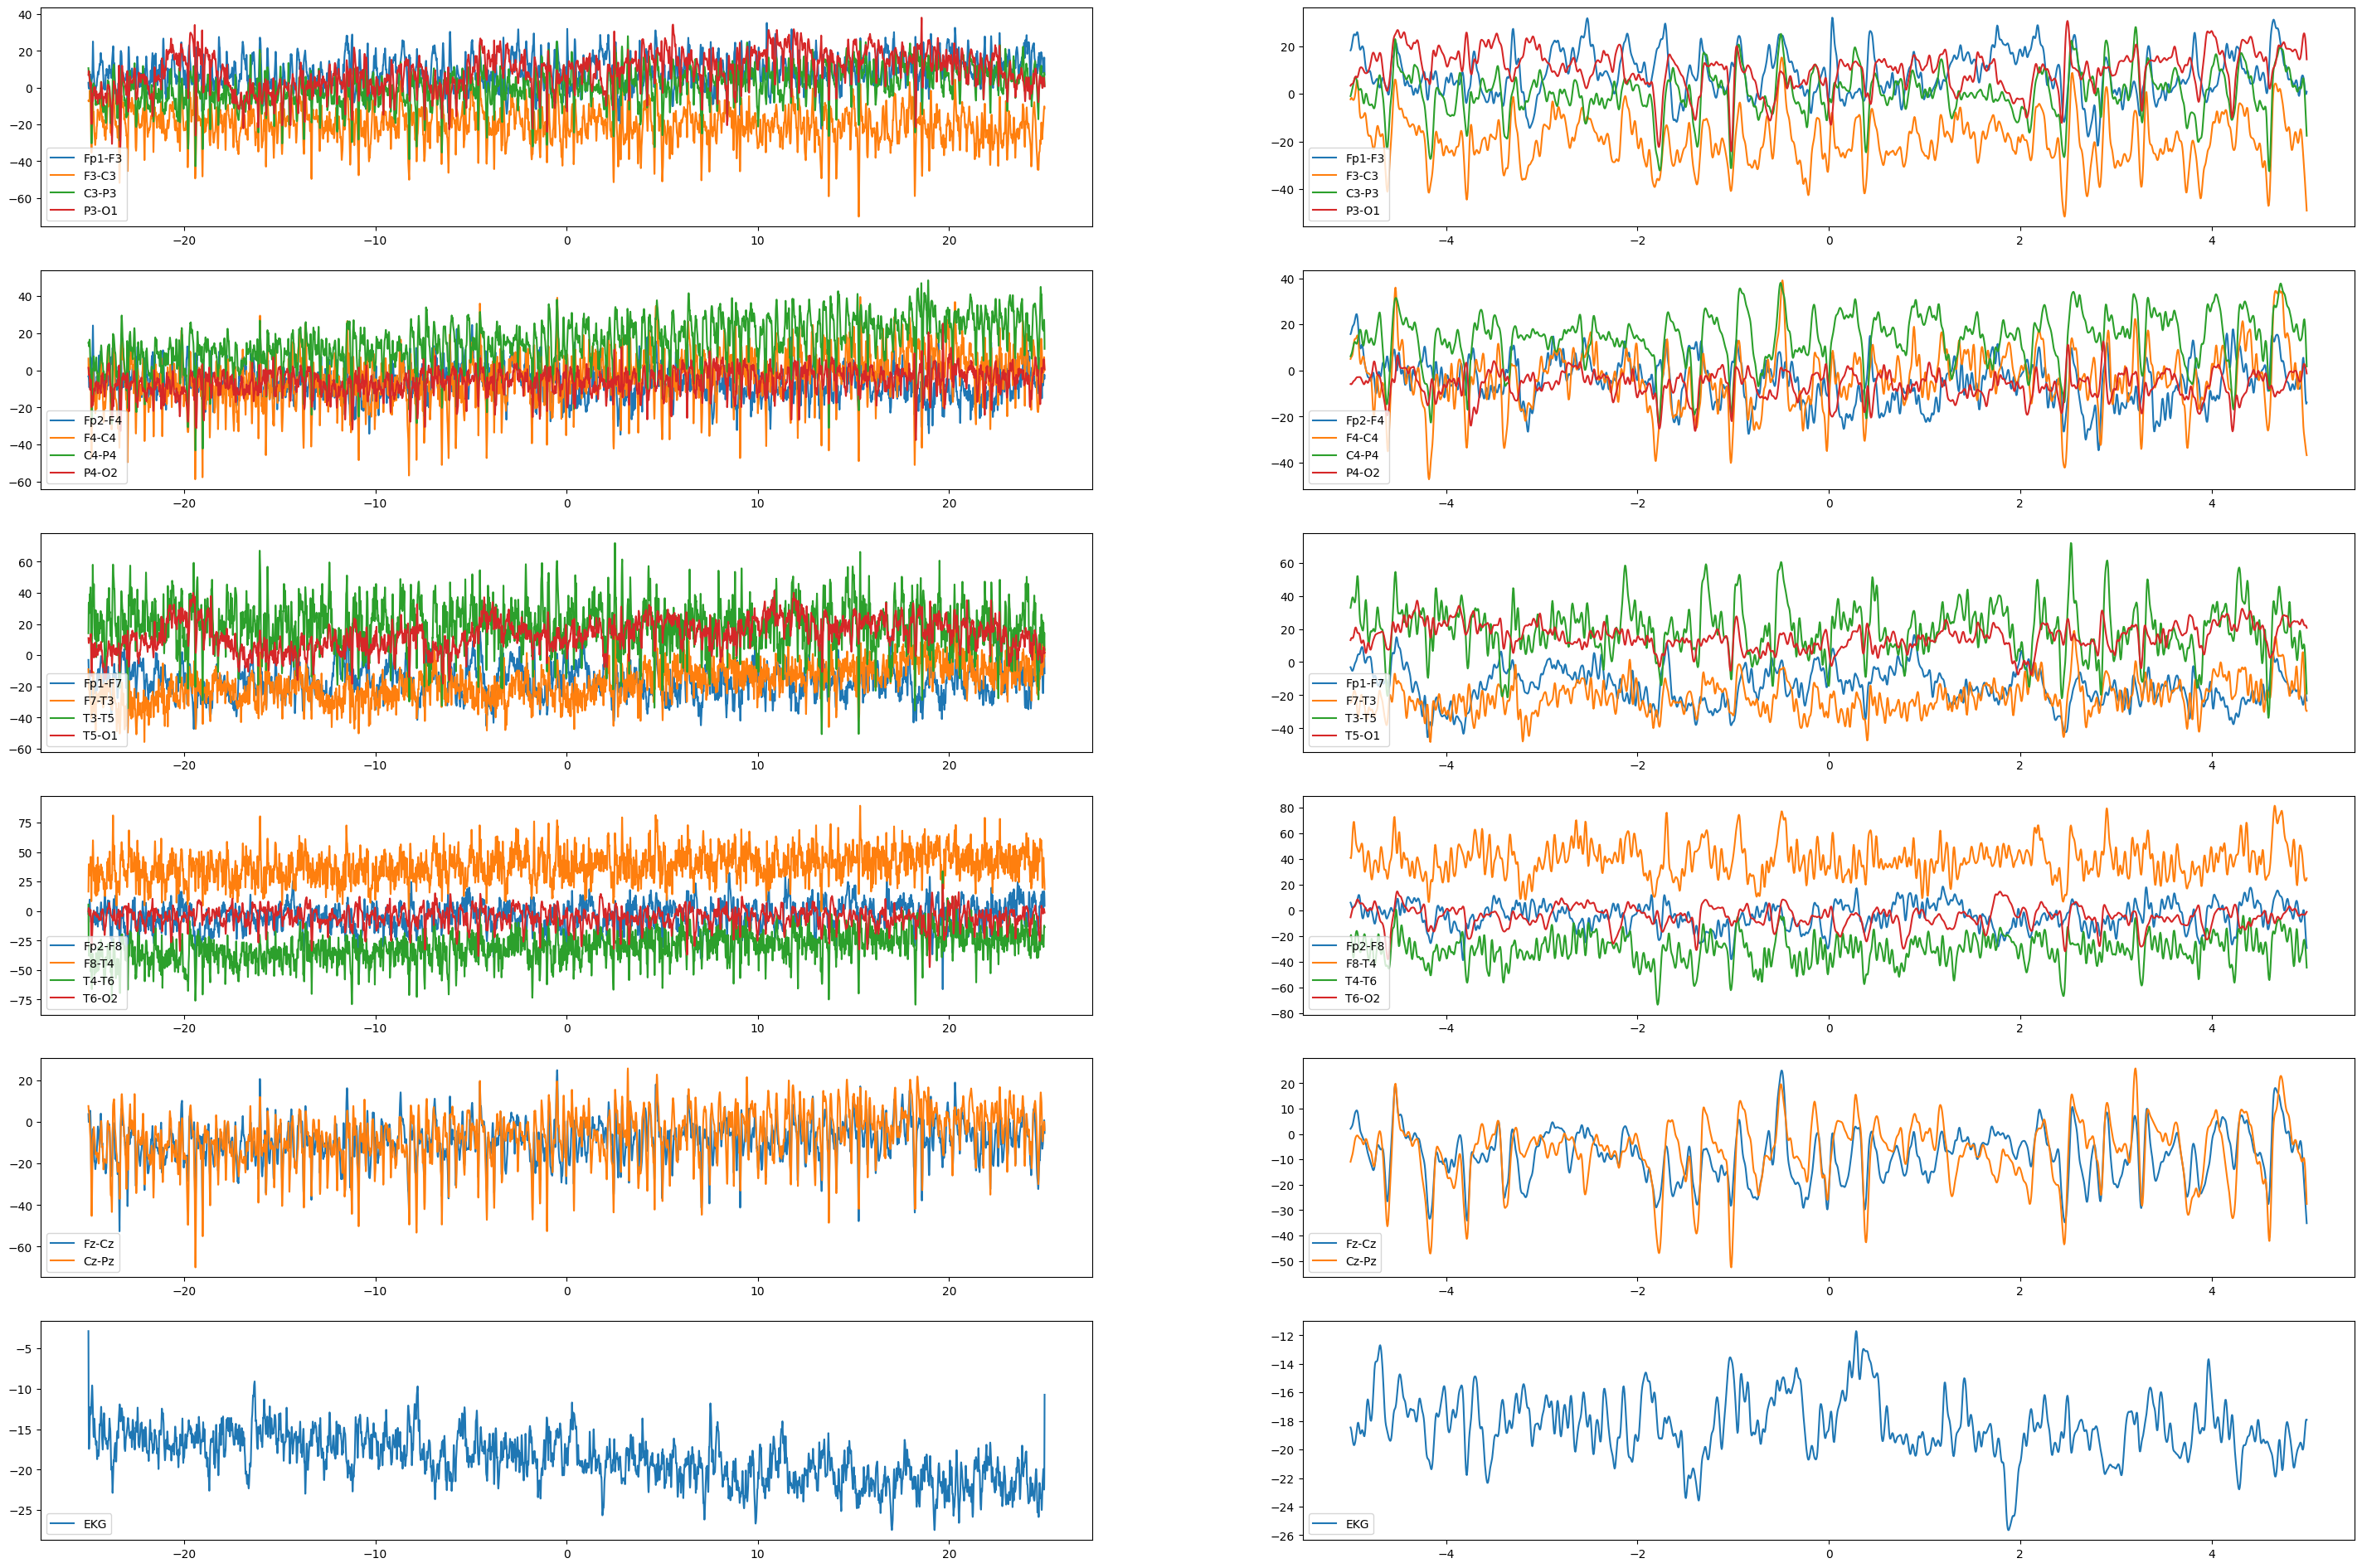

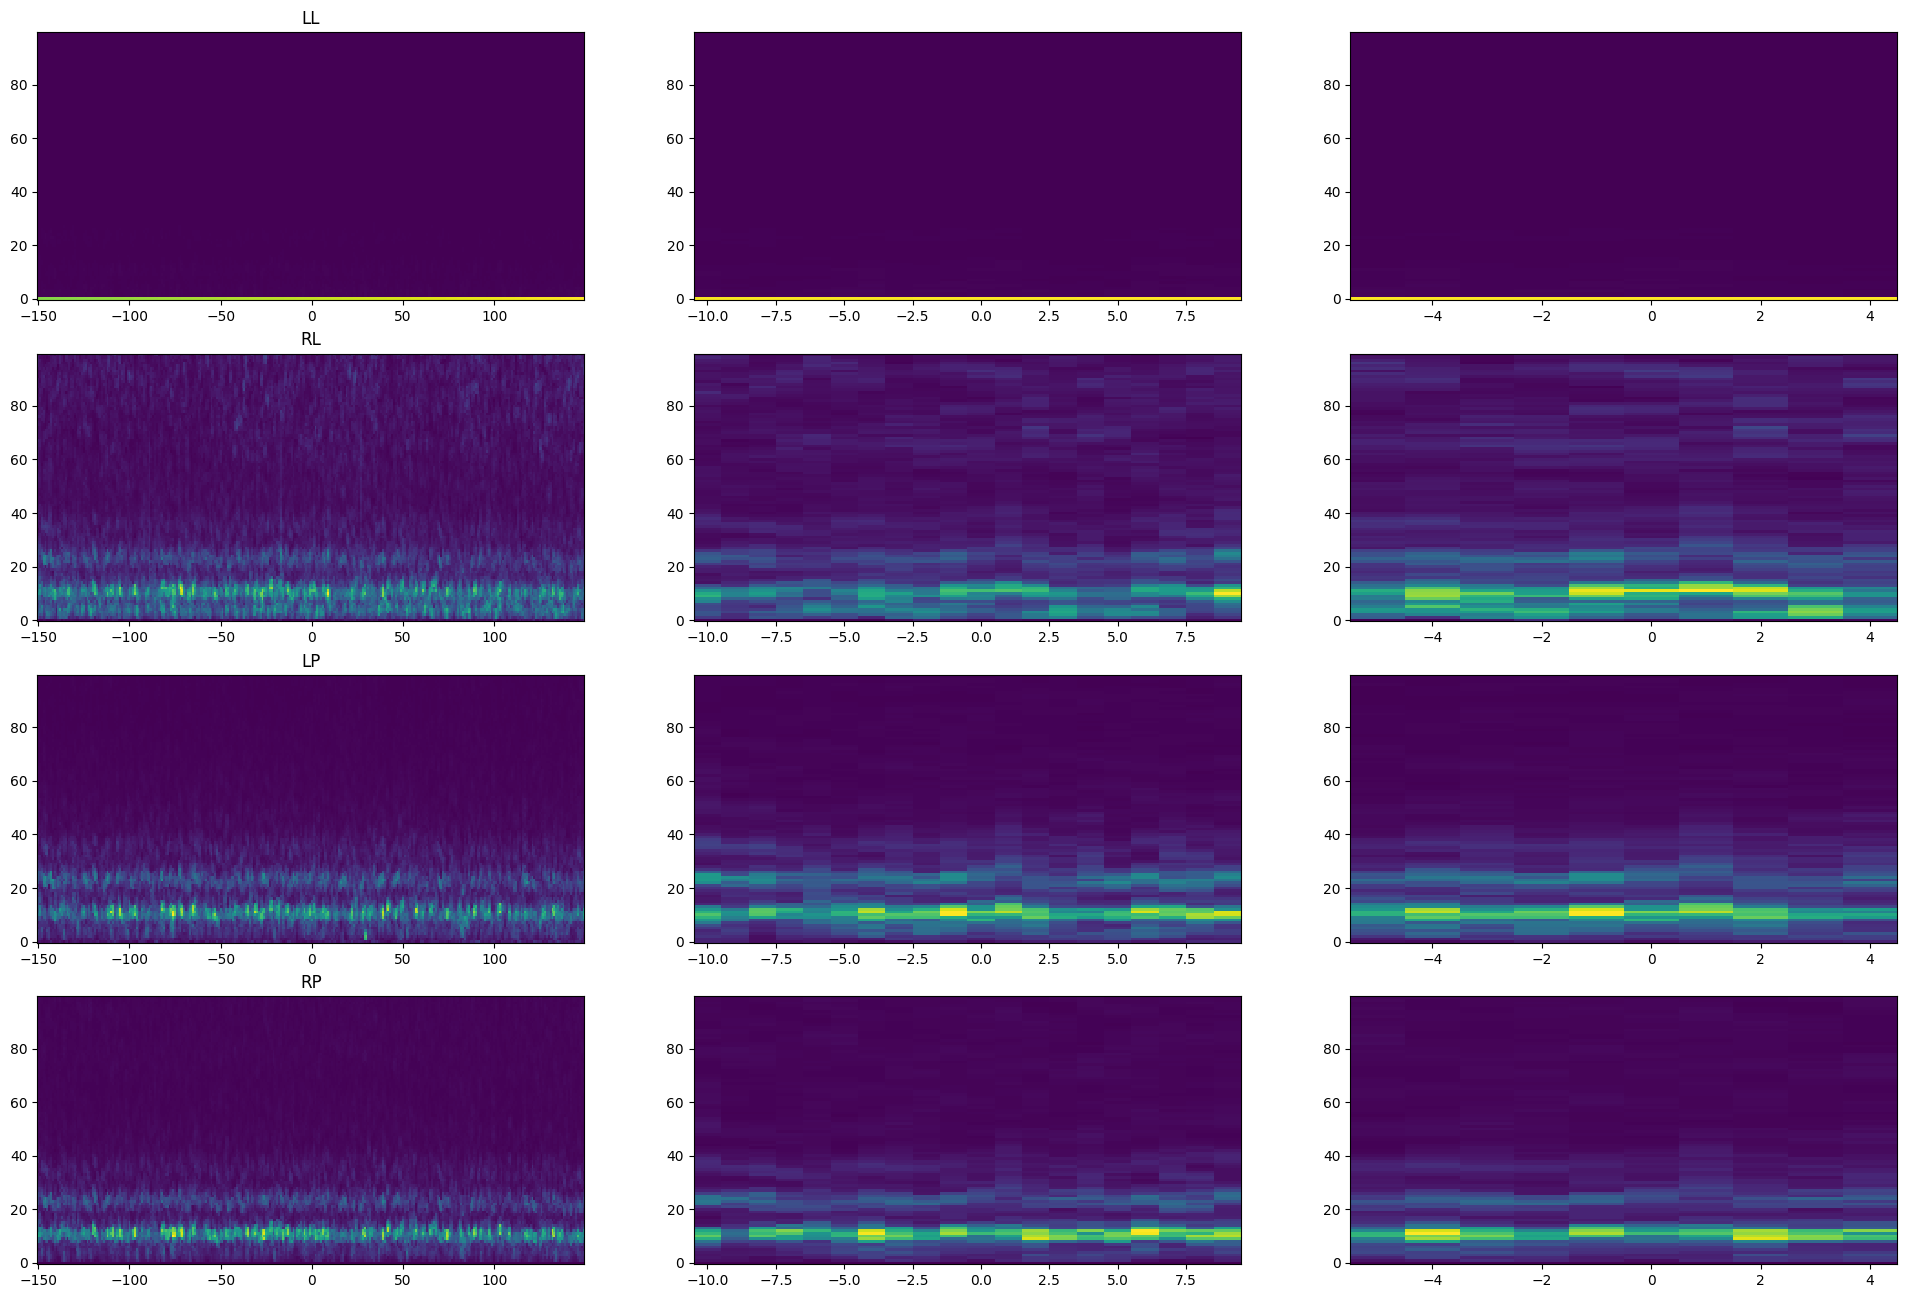

In [3]:
item_id = 814

sg, eeg, label = get_train_item(item_id)

view_eeg(eeg)
view_sg(sg)

# Dump a compact verison of all data

In [4]:
sg_data, eeg_data = [], []
N = 10000
for n in range(len(df_train)):
    if ((n + 1) % N == 0):
        print(n + 1)
        with open(f'sg_{n // N}.pkl', 'wb') as f:
            pickle.dump(np.stack(sg_data), f)
        with open(f'eeg_{n // N}.pkl', 'wb') as f:
            pickle.dump(np.stack(eeg_data), f)
        
        sg_data, eeg_data = [], []
    sg, eeg, label = get_train_item_small(n)
    
    sg_data.append(sg)
    eeg_data.append(eeg)
    
with open(f'sg_{n // N}.pkl', 'wb') as f:
    pickle.dump(np.stack(sg_data), f)
with open(f'eeg_{n // N}.pkl', 'wb') as f:
    pickle.dump(np.stack(eeg_data), f)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
